In [1]:
import matplotlib
from redbaron import redbaron
redbaron.ipython_behavior = False

import numpy as np
from scipy import signal
from pyha import common
from pyha.common.util import plot_freqz
from pyha import simulate, hardware_sims_equal

# add dev folder to path in order to import our module
import os, sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from pyha_demo_project.complex_fir import ComplexFIR

# set 'run_as_baseline' to True and run 'Restart & Run all' before you commit this notebook, else you will get failed tests in CI.
# also consider running in virtualenvironment, tests may fail if, for example, matplotlib versions differ
# use False for experimenting with larger figures + run the GATE simulations
run_as_baseline = True
if not run_as_baseline:
    matplotlib.use('nbagg')
    import matplotlib.pyplot as plt
    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 5
    %load_ext autoreload
    %autoreload 2
else:
    import matplotlib.pyplot as plt
    # this ignores some 'log' warnings that would fail the unit tests as they include system path
    import warnings
    warnings.filterwarnings('ignore')
# in Travis CI we cannot run GATE simulations, comment out to run GATE simulations locally
os.environ["PYHA_SKIP_GATE"] = '1'

# Design filter

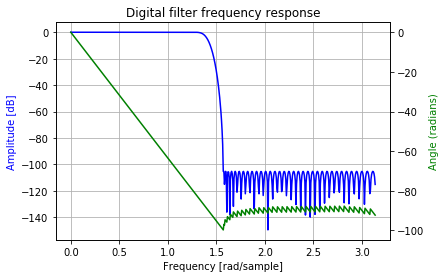

In [2]:
taps = signal.remez(128, [0, 0.2, 0.25, 0.5], [1, 0])
plot_freqz(taps)

# Evaluate frequency and phase response

In [3]:
# get imulse response of the filter
inp = [0.0 + 0.0j] * 512
inp[0] = 1.0 + 1.0j

dut = ComplexFIR(taps)
sims = simulate(dut, inp) # run all simulations
assert hardware_sims_equal(sims)

INFO:simulation:Running MODEL simulation!
INFO:simulation:Running PYHA simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running RTL simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running COCOTB & GHDL simulation....
INFO:simulation:Simulations completed!
INFO:simulation:sims_close(rtol=1e-08, atol=1e-08)
INFO:simulation:Using "PYHA" as golden output
INFO:simulation:PYHA OK!
INFO:simulation:RTL OK!


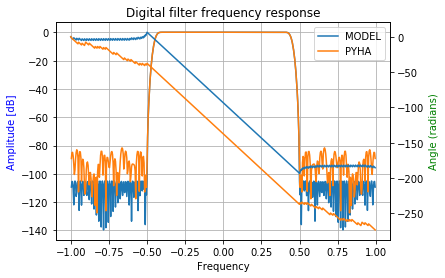

In [4]:
gain_fix = 512-128-16
fig, ax1 = plt.subplots(1, 1)
plt.title('Digital filter frequency response')
ax1.magnitude_spectrum(np.array(sims['MODEL']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='MODEL')
ax1.magnitude_spectrum(np.array(sims['PYHA']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='PYHA')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency')
plt.grid(True)
ax2 = ax1.twinx()
ax2.phase_spectrum(np.array(sims['MODEL']), window=matplotlib.mlab.window_none, label='MODEL')
ax2.phase_spectrum(np.array(sims['PYHA']), window=matplotlib.mlab.window_none, label='PYHA')
ax2.set_ylabel('Angle (radians)', color='g')
plt.legend()
plt.show()

# Noise response

In [5]:
np.random.seed(0)  # reproduce tests
inp = np.random.uniform(-1, 1, 512) + np.random.uniform(-1, 1, 512)*1j
inp *= 0.75

dut = ComplexFIR(taps)
sims = simulate(dut, inp) # run all simulations
assert hardware_sims_equal(sims)

INFO:simulation:Running MODEL simulation!
INFO:simulation:Running PYHA simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running RTL simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running COCOTB & GHDL simulation....
INFO:simulation:Simulations completed!
INFO:simulation:sims_close(rtol=1e-08, atol=1e-08)
INFO:simulation:Using "PYHA" as golden output
INFO:simulation:PYHA OK!
INFO:simulation:RTL OK!


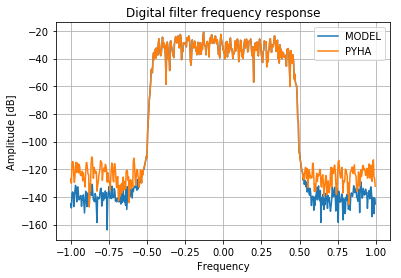

In [6]:
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='PYHA')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

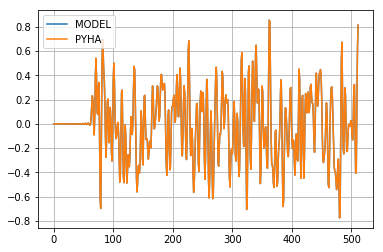

In [7]:
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='PYHA')
plt.grid(True)
plt.legend()
plt.show()

# Sine response

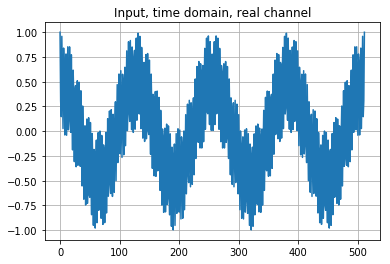

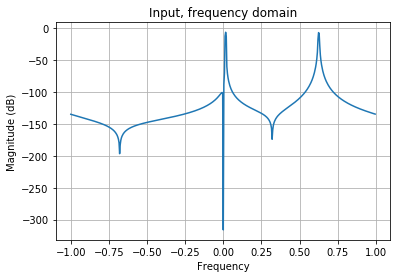

In [8]:
fs = 256
t = np.linspace(0, 2, 2*fs)
s0 = np.exp(2 * np.pi * 2 * t * 1j)
s1 = np.exp(2 * np.pi * 80 * t * 1j)
inp = s0 + s1
inp *= 0.5

plt.title('Input, time domain, real channel')
plt.plot(inp.real)
plt.grid(True)
plt.show()

plt.title('Input, frequency domain')
plt.magnitude_spectrum(inp, scale='dB')
plt.grid(True)
plt.show()

In [9]:
dut = ComplexFIR(taps)
sims = simulate(dut, inp) # run all simulations
assert hardware_sims_equal(sims)

INFO:simulation:Running MODEL simulation!
INFO:simulation:Running PYHA simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running RTL simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running COCOTB & GHDL simulation....
INFO:simulation:Simulations completed!
INFO:simulation:sims_close(rtol=1e-08, atol=1e-08)
INFO:simulation:Using "PYHA" as golden output
INFO:simulation:PYHA OK!
INFO:simulation:RTL OK!


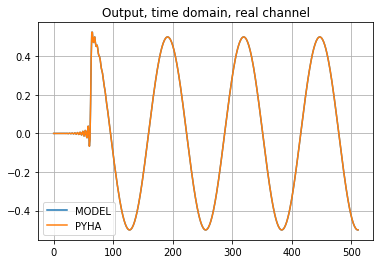

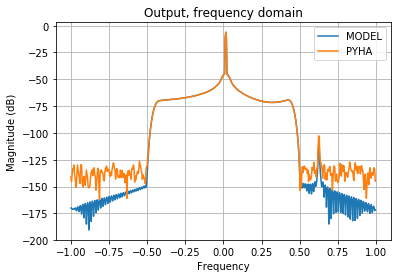

In [10]:
plt.title('Output, time domain, real channel')
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='PYHA')
plt.legend()
plt.grid()
plt.show()

plt.title('Output, frequency domain')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='PYHA')
plt.legend()
plt.grid()
plt.show()